In [1]:
from datetime import datetime

now = datetime.now()
print(f"Run Start Time: {now}")

Run Start Time: 2021-01-08 06:58:07.356583


In [2]:
# Pre Release
import sys
from pprint import pprint

sys.path.append(os.environ["DEV_SKTIME"])

# print(os.environ['DEV_SKTIME'])

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.all import *
%matplotlib inline

In [5]:
from sktime import show_versions

show_versions()


System:
    python: 3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\sktime_dev\python.exe
   machine: Windows-10-10.0.18362-SP0

Python dependencies:
          pip: 20.3.3
   setuptools: 51.0.0.post20201207
      sklearn: 0.24.0
       sktime: 0.5.1
  statsmodels: 0.12.1
        numpy: 1.19.4
        scipy: 1.5.4
       Cython: 0.29.17
       pandas: 1.1.5
   matplotlib: 3.3.3
       joblib: 1.0.0
        numba: 0.52.0
     pmdarima: 1.8.0
      tsfresh: 0.17.0


## Setup

In [6]:
y = load_airline()

In [7]:
y = y[:48]
len(y)

48

In [8]:
window_length = 18  # How much of previous history to use to train
fh = np.arange(1, 13)  # How much to forecast (from 1 to 12 or 1 year)
step_length = 1  # How much to step the sliding window

## Simple temporal split

(48,) 36 12
PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10', '1949-11', '1949-12',
             '1950-01', '1950-02', '1950-03', '1950-04', '1950-05', '1950-06',
             '1950-07', '1950-08', '1950-09', '1950-10', '1950-11', '1950-12',
             '1951-01', '1951-02', '1951-03', '1951-04', '1951-05', '1951-06',
             '1951-07', '1951-08', '1951-09', '1951-10', '1951-11', '1951-12',
             '1952-01', '1952-02', '1952-03', '1952-04', '1952-05', '1952-06',
             '1952-07', '1952-08', '1952-09', '1952-10', '1952-11', '1952-12'],
            dtype='period[M]', name='Period', freq='M')


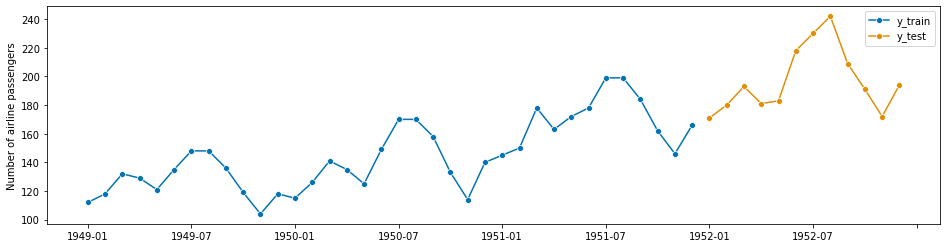

In [9]:
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y.shape, y_train.shape[0], y_test.shape[0])
print(y.index)

## Single Window Splitter

#### Without Window Length Specified

This functions very much like the `temporal_train_test_split` above

In [ ]:
cv_single1 = SingleWindowSplitter(fh=fh)

In [ ]:
n_splits = cv_single1.get_n_splits(y)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_single1.split(y)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

### With Window Length Specified

In this case, the window length is fixed

In [ ]:
cv_single2 = SingleWindowSplitter(window_length=window_length, fh=fh)

In [ ]:
n_splits = cv_single2.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_single2.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

### Cutoff Splitter

* Manually Specify the Cutoff points
* Cutoff indicates the last index of the training data

In [ ]:
cv_cutoff1 = CutoffSplitter(
    cutoffs=np.array([12, 15, 18]), window_length=window_length, fh=fh
)

In [ ]:
n_splits = cv_cutoff1.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_cutoff1.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

## Sliding Window Splitter

The code below is a breakdown of the code found in the library for understanding the internal working. 

Refer to **https://github.com/alan-turing-institute/sktime/issues/518** for questions related to this evaluation

In [ ]:
help(SlidingWindowSplitter)

Method resolution order:

    SlidingWindowSplitter
        - Attributes
            - self.step_length
            - self.initial_window
            - self.start_with_window        
        - Methods
            - Other Methods
        
    BaseWindowSplitter
        - Attributes
            - None
        - Methods
            - get_end()
    
    BaseSplitter
        - Attributes
            - self.window_length
            - self.fh            
        - Methods
            - No direct useful ones (some housekeeping, some abstract)
    
    builtins.object

### start_with_window=True

In [ ]:
# For training the regressor
initial_window = int(len(y_train) * 0.5)

cv_sliding1 = SlidingWindowSplitter(
    initial_window=initial_window,
    window_length=window_length,
    fh=fh,
    step_length=step_length,
    start_with_window=True,
)

#### Behavior

In [ ]:
n_splits = cv_sliding1.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_sliding1.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

#### Initial Split 

In [ ]:
# help(cv_sliding1.split_initial)

In [ ]:
# Splits the data
# Reserves "Initial Window" for Training and the rest for "Testing"
# According to documentation, forcaster is fit on the train indeices and
# cv is done on test indices
train_indices, test_indices = cv_sliding1.split_initial(y_train)
print(f"Train Indices: {train_indices}\n\nTest Indices: {test_indices}")

#### Sliding Window Splits

In [ ]:
end = cv_sliding1._get_end(y_train)
start = cv_sliding1._get_start()
print(f"Start: {start} End: {end}")

In [ ]:
cutoffs = cv_sliding1.get_cutoffs(y_train)
n_splits = cv_sliding1.get_n_splits(y_train)
print(
    f"Cutoffs: {cutoffs},\nLength of Cutoffs = {len(cutoffs)} = Number of Splits = {n_splits}"
)

In [ ]:
for split_point in range(start, end, step_length):
    training_window = np.arange(split_point - window_length, split_point)
    test_window = split_point + fh - 1
    print(training_window, test_window)

### start_with_window=False

In [ ]:
# For training the regressor
initial_window = int(len(y_train) * 0.5)

cv_sliding2 = SlidingWindowSplitter(
    initial_window=initial_window,
    window_length=window_length,
    fh=fh,
    step_length=step_length,
    start_with_window=False,
)

#### Behavior

In [ ]:
n_splits = cv_sliding2.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_sliding2.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

#### Initial Split

In [ ]:
train_indices, test_indices = cv_sliding2.split_initial(y_train)
print(f"Train Indices: {train_indices}\n\nTest Indices: {test_indices}")

#### Sliding Window Splits

In [ ]:
end = cv_sliding2._get_end(y_train)
start = cv_sliding2._get_start()
print(f"Start: {start} End: {end}")

In [ ]:
cutoffs = cv_sliding2.get_cutoffs(y_train)
n_splits = cv_sliding2.get_n_splits(y_train)
print(
    f"Cutoffs: {cutoffs},\nLength of Cutoffs = {len(cutoffs)} = Number of Splits = {n_splits}"
)

In [ ]:
for split_point in range(start, end, step_length):
    training_window = np.arange(split_point - window_length, split_point)
    test_window = split_point + fh - 1
    print(training_window, test_window)

### start_with_window=True (Full Values)

In [ ]:
# For training the regressor
initial_window = int(len(y_train) * 0.99)  # 0.5

cv_sliding1 = SlidingWindowSplitter(
    initial_window=initial_window,
    window_length=window_length,
    fh=fh,
    step_length=step_length,
    start_with_window=True,
)

#### Behavior

In [ ]:
n_splits = cv_sliding1.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_sliding1.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

#### Initial Split 

In [ ]:
# help(cv_sliding1.split_initial)

In [ ]:
# Splits the data
# Reserves "Initial Window" for Training and the rest for "Testing"
# According to documentation, forcaster is fit on the train indeices and
# cv is done on test indices
train_indices, test_indices = cv_sliding1.split_initial(y_train)
print(f"Train Indices: {train_indices}\n\nTest Indices: {test_indices}")

#### Sliding Window Splits

In [ ]:
end = cv_sliding1._get_end(y_train)
start = cv_sliding1._get_start()
print(f"Start: {start} End: {end}")

In [ ]:
cutoffs = cv_sliding1.get_cutoffs(y_train)
n_splits = cv_sliding1.get_n_splits(y_train)
print(
    f"Cutoffs: {cutoffs},\nLength of Cutoffs = {len(cutoffs)} = Number of Splits = {n_splits}"
)

In [ ]:
for split_point in range(start, end, step_length):
    training_window = np.arange(split_point - window_length, split_point)
    test_window = split_point + fh - 1
    print(training_window, test_window)

In [ ]:
# # Some visualization: https://github.com/alan-turing-institute/sktime/issues/477

# from matplotlib.ticker import MaxNLocator

# y = load_airline()[:30]

# window_length = 10
# fh = ForecastingHorizon(np.arange(3))
# fh_length = len(fh)

# cv = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)
# n_splits = cv.get_n_splits(y)

# windows = np.empty((n_splits, window_length), dtype=np.int)
# fhs = np.empty((n_splits, fh_length), dtype=np.int)
# for i, (w, f) in enumerate(cv.split(y)):
#     windows[i] = w
#     fhs[i] = f

# fig, ax = plt.subplots(1)

# window_color, fh_color = sns.color_palette("colorblind")[:2]

# def get_y(length, split):
#     return np.ones(length) * split

# for i in range(n_splits):
#     ax.plot(windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window")
#     ax.plot(fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon")

# ax.invert_yaxis()
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set(ylabel="Window number", xlabel="Time", xticklabels=y.index);

# # remove duplicate labels/handles
# handles, labels = [(l[:2]) for l in ax.get_legend_handles_labels()]
# # ax.legend(handles, labels)

## scikit-learn models

In [ ]:
print(initial_window, int(len(y_train) * 0.5), window_length, fh, step_length)

In [ ]:
FH = np.arange(1,4)
FH

In [ ]:
fh

In [ ]:
ReducedRegressionForecaster?

In [10]:
# Simple Baseline (with non-stationary data)
# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
# regressor_param_grid = {"n_estimators": [100, 200, 300]}
regressor_param_grid = {"n_estimators": [200]}
forecaster_param_grid = {"window_length": [12, 15]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid, verbose=1)
forecaster = ReducedRegressionForecaster(
    regressor, window_length=window_length, strategy="recursive"
)

# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
cv = SlidingWindowSplitter(
    initial_window=20,
    # window_length=10,
    # fh=fh,
    # step_length=step_length,
    start_with_window=True,
)

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=1)

gscv.fit(y_train)
# y_pred = gscv.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# smape_loss(y_test, y_pred)

Fitting 26 folds for each of 2 candidates, totalling 52 fits
_tune.py --> Length of y: 36
_tune.py --> Parameters: {'window_length': 12}
_tune.py --> _fit_and_score Initial Split: y_train PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10', '1949-11', '1949-12',
             '1950-01', '1950-02', '1950-03', '1950-04', '1950-05', '1950-06',
             '1950-07', '1950-08'],
            dtype='period[M]', name='Period', freq='M'), y_val PeriodIndex(['1950-09', '1950-10', '1950-11', '1950-12', '1951-01', '1951-02',
             '1951-03', '1951-04', '1951-05', '1951-06', '1951-07', '1951-08',
             '1951-09', '1951-10', '1951-11', '1951-12'],
            dtype='period[M]', name='Period', freq='M')
_tune.py --> _fit_and_score Forecaster: RecursiveRegressionForecaster(regressor=GridSearchCV(estimator=RandomForestRegressor(),
                                                     param_grid={'n_estimato

ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x000002B29A2D6898>,
                        forecaster=RecursiveRegressionForecaster(regressor=GridSearchCV(estimator=RandomForestRegressor(),
                                                                                        param_grid={'n_estimators': [200]},
                                                                                        verbose=1),
                                                                 window_length=18),
                        param_grid={'window_length': [12, 15]}, verbose=1)

In [ ]:
cv.get_n_splits(y_train)